<a href="https://www.kaggle.com/code/pronoydeb/convnext-model?scriptVersionId=266664798" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:coral"> <center> ConvNeXt with tensorflow</center> </span>

# <span >Notebook Overview</span>

* In this notebook I have implemented `ConvNext tiny` model from the research paper titled as [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) using tensorflow.

* The code in this notebook is reusable and can be reused with any dataset of your choice.

* In this notebook I will train `ConvNext tiny` model from scratch on CIFAR-10 dataset.


In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Conv2D
import cv2

# <span style="color:coral">Loading Data</span>

In [3]:
# Path to dataset
data_path = "/kaggle/input/severity-based-rice-disease-final/severity-based-rice-disease-final"

def safe_label(name: str):
    """Convert folder name into safe label"""
    return name.strip().replace(" ", "_").replace("-", "_")

def load_leaf_disease_dataset(dataset_path, img_size=(224, 224)):
    def load_subset(subset):
        images = []
        labels = []
        subset_path = os.path.join(dataset_path, subset)

        for disease_name in os.listdir(subset_path):
            disease_path = os.path.join(subset_path, disease_name)
            if os.path.isdir(disease_path):
                safe_name = safe_label(disease_name)  # <-- use safe name here
                for img_file in os.listdir(disease_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(disease_path, img_file)
                        try:
                            img = Image.open(img_path).convert("RGB")
                            img = img.resize(img_size)
                            images.append(np.array(img))
                            labels.append(safe_name)   # <-- append safe label
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")
        return np.array(images), np.array(labels)

    # Load train, validation, and test separately
    x_train, y_train = load_subset("train")
    x_val, y_val = load_subset("validation")
    x_test, y_test = load_subset("test")

    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), le.classes_

# Load data
(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_leaf_disease_dataset(data_path)

# Normalize images (0–1)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print(f"Classes detected: {class_names}")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

# -------------------------
# Data Augmentation (only for training)
# -------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit generator to training data
datagen.fit(x_train)

train_dir = data_path + "/train"
val_dir = data_path + "/validation"
test_dir = data_path + "/test"

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = (x_test, y_test)  # no augmentation for test

Classes detected: ['Healthy' 'Mild_Bacterial_blight' 'Mild_Blast' 'Mild_Brownspot'
 'Mild_Tungro' 'Severe_Bacterial_blight' 'Severe_Blast' 'Severe_Brownspot'
 'Severe_Tungro']
x_train: (2402, 224, 224, 3), y_train: (2402,)
x_val: (424, 224, 224, 3), y_val: (424,)
x_test: (180, 224, 224, 3), y_test: (180,)
Found 2402 images belonging to 9 classes.
Found 424 images belonging to 9 classes.
Found 180 images belonging to 9 classes.


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.
​
td.data allows us to do various tasks in memory efficient way such as :
​
* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed

In [4]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=32
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

# <center>ConvNeXt Block</center>

For implementing `ConvNeXt` block authors take inspiration from the `ResNext` architecture which use [grouped convolutions](https://paperswithcode.com/method/grouped-convolution#:~:text=A%20Grouped%20Convolution%20uses%20a,level%20and%20high%20level%20features.), for `ConvNeXt` block authors utlize the combination of [depthwise convolutions](https://paperswithcode.com/method/depthwise-convolution) and 1x1 [point-wise convolutions](https://paperswithcode.com/method/pointwise-convolution). Depthwise convolutions reduce the number of parameters and computation used in convolutional operations while increasing representational efficiency. Pointwise convolutions is a 1x1 convolution which projects the channels output by the depthwise convolution onto a new channel space
 
In this paper authors use a slightly modified [inverted bottle-neck](https://paperswithcode.com/method/inverted-residual-block) design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A [GELU](https://paperswithcode.com/method/gelu) activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.

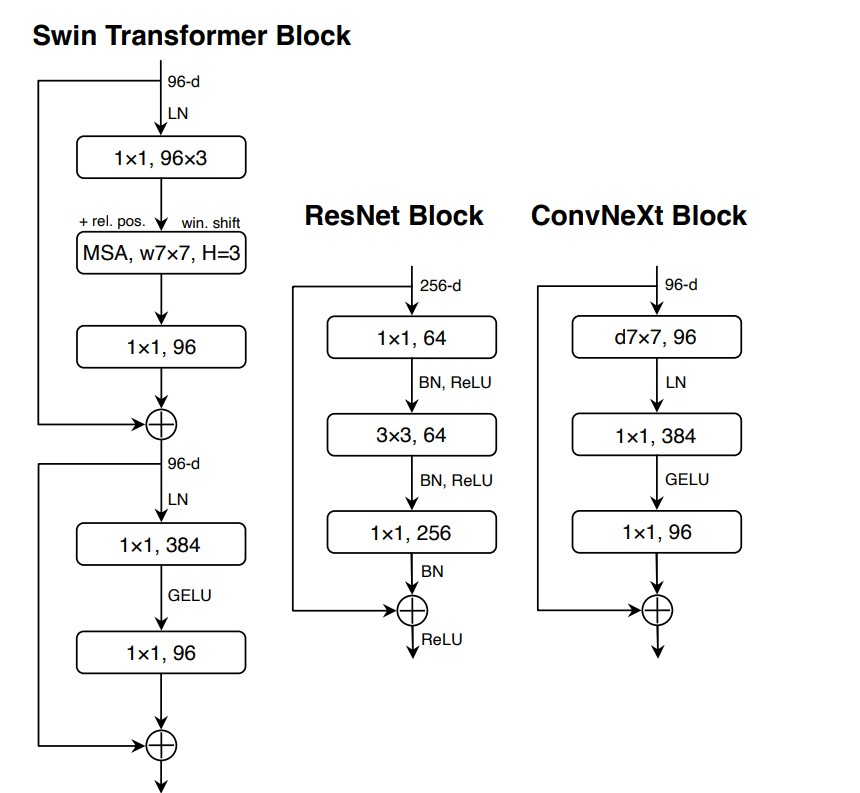

> Image source [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) 

In [5]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        
    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)

# Patchify Stem 

For processing the input images, ConvNeXt utilizes patchify strategy of transformers by 4x4 convolutional layer with stride of 4 i.e it will have non overlapping patches.

In [6]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling

Similar to Resnets and Swin Transformer, ConvNext perform spatial downsampling with `2x2` conv layer having `stride` of **2**. Authors of the paper observed that adding Layer Normalization layer gives significantly good performance.



In [7]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages
We will iteratively build the stages of ConvNeXt block by calling the ConvNext_Block function created earlier over the feature dimensions at each stage.

In [8]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model

In this implementaion I will be implementing the ConvNeXt-T having dimensions = (96, 192, 224, 768) and depths = (3, 3, 9, 3)

In [9]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[1, 1, 1, 1]
depths=[3, 3, 9, 3]

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [11]:
inputs = layers.Input((32,32,3))
x = data_augmentation(inputs)

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [12]:
ConvNeXt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 1)           51        
_________________________________________________________________
sequential_5 (Sequential)    (None, 8, 8, 1)           198       
_________________________________________________________________
sequential_2 (Sequential)    (None, 4, 4, 1)           7         
_________________________________________________________________
sequential_6 (Sequential)    (None, 4, 4, 1)           198       
_________________________________________________________________
sequential_3 (Sequential)    (None, 2, 2, 1)           7     

In [13]:
class MetricsLogger(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.y_true = []
        self.y_pred = []

    def on_test_end(self, logs=None):  # called at the end of validation/testing
        y_true = []
        y_pred = []
        
        for batch in self.validation_data:
            images, labels = batch
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)

        # print classification report
        print("\nFinal Validation Classification Report:\n")
        print(classification_report(y_true, y_pred, zero_division=0))

In [14]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # freeze backbone

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(9, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_cb_stage1 = tf.keras.callbacks.ModelCheckpoint(
    "best_model_stage1.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    save_format="h5"
)

checkpoint_cb_stage2 = tf.keras.callbacks.ModelCheckpoint(
    "best_model_stage2.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    save_format="h5"
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Stage 1: Train top layers only
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint_cb_stage1, early_stop]
)
model.load_weights("best_model_stage1.h5")

# Stage 2: Fine-tune last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[checkpoint_cb_stage2, early_stop]
)
model.load_weights("best_model_stage2.h5")

43950080/43941136 [==============================] - 0s 0us/step
Epoch 1/15
76/76 [==============================] - 186s 2s/step - loss: 1.2706 - accuracy: 0.5783 - val_loss: 0.7872 - val_accuracy: 0.7665


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
76/76 [==============================] - 162s 2s/step - loss: 0.7262 - accuracy: 0.7631 - val_loss: 0.6201 - val_accuracy: 0.8137
Epoch 3/15
76/76 [==============================] - 163s 2s/step - loss: 0.5878 - accuracy: 0.8047 - val_loss: 0.5071 - val_accuracy: 0.8538
Epoch 4/15
76/76 [==============================] - 163s 2s/step - loss: 0.5347 - accuracy: 0.8268 - val_loss: 0.4553 - val_accuracy: 0.8491
Epoch 5/15
76/76 [==============================] - 163s 2s/step - loss: 0.4857 - accuracy: 0.8410 - val_loss: 0.4514 - val_accuracy: 0.8467
Epoch 6/15
76/76 [==============================] - 160s 2s/step - loss: 0.4554 - accuracy: 0.8451 - val_loss: 0.4298 - val_accuracy: 0.8679
Epoch 7/15
76/76 [==============================] - 160s 2s/step - loss: 0.4241 - accuracy: 0.8551 - val_loss: 0.3943 - val_accuracy: 0.8726
Epoch 8/15
76/76 [==============================] - 160s 2s/step - loss: 0.4107 - accuracy: 0.8593 - val_loss: 0.3803 - val_accuracy: 0.8774
Epoch 9/15
76

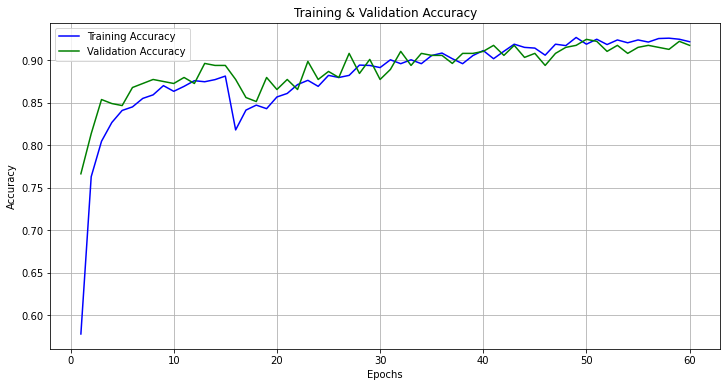

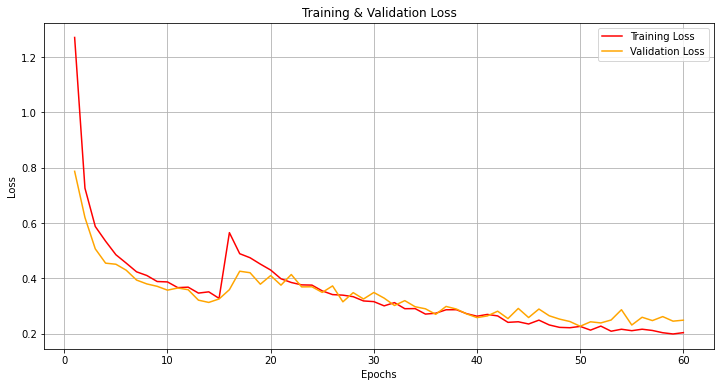

In [15]:
# Merge histories from both training phases
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
import pandas as pd

# Load best model
best_model = tf.keras.models.load_model("best_model_stage2.h5")

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_loss, test_acc = best_model.evaluate(test_gen, verbose=1)
print("Test accuracy:", test_acc)

# Predictions
y_pred_probs = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

results_df = pd.DataFrame({
    "Filename": test_gen.filenames,
    "TrueLabelIndex": y_true,
    "TrueLabel": [class_names[i] for i in y_true],
    "PredictedLabelIndex": y_pred,
    "PredictedLabel": [class_names[i] for i in y_pred]
})

# Add predicted probabilities for each class
for i, label in enumerate(class_names):
    results_df[f"Prob_{label}"] = y_pred_probs[:, i]

# Save to CSV
results_df.to_csv("model_results_efficientnetb3.csv", index=False)

print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

Found 180 images belonging to 9 classes.
6/6 [==============================] - 14s 1s/step - loss: 0.2873 - accuracy: 0.9278
Test accuracy: 0.9277777671813965
6/6 [==============================] - 16s 1s/step
                         precision    recall  f1-score   support

                Healthy       1.00      1.00      1.00        20
  Mild Bacterial blight       0.90      0.90      0.90        20
             Mild Blast       0.94      0.85      0.89        20
         Mild Brownspot       0.86      0.95      0.90        20
            Mild Tungro       0.95      1.00      0.98        20
Severe Bacterial blight       0.90      0.90      0.90        20
           Severe Blast       0.90      0.95      0.93        20
       Severe Brownspot       1.00      0.95      0.97        20
          Severe Tungro       1.00      0.95      0.97        20

               accuracy                           0.94       180
              macro avg       0.94      0.94      0.94       180
       

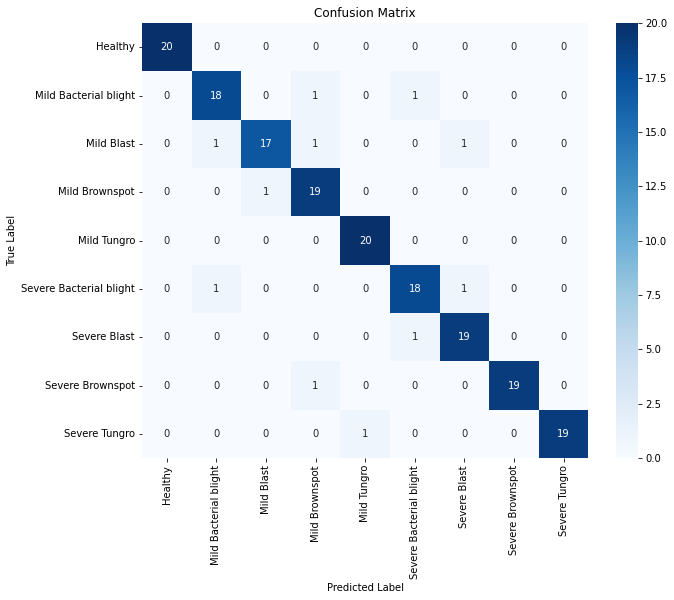

y_test size: 180
y_pred size: 180


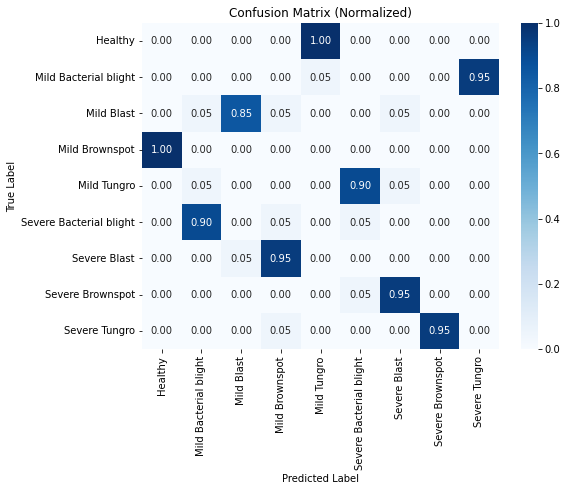

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

print("y_test size:", len(y_test))
print("y_pred size:", len(y_pred))

# Build confusion matrix with explicit number of classes
num_classes = len(class_names)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))

# Normalize safely
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # replace NaNs with 0

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()

Using layer: top_conv


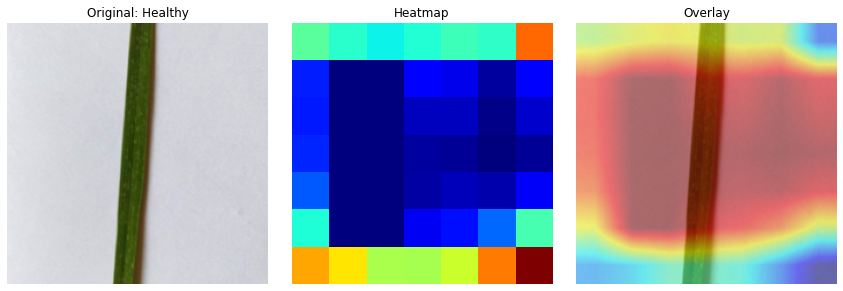

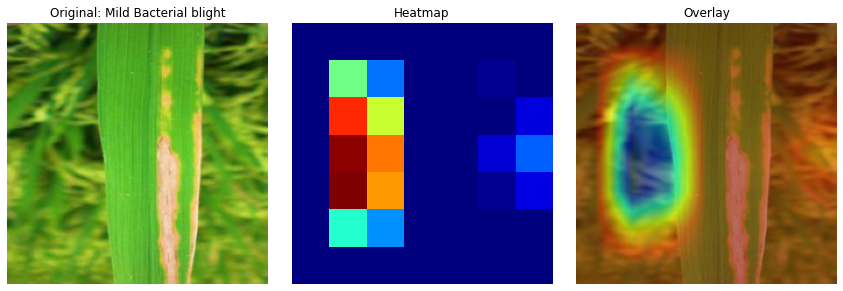

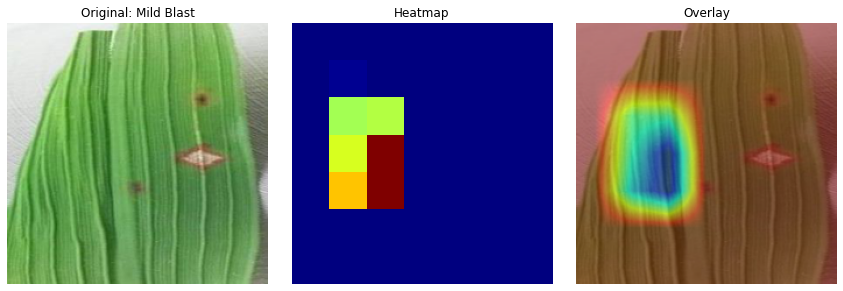

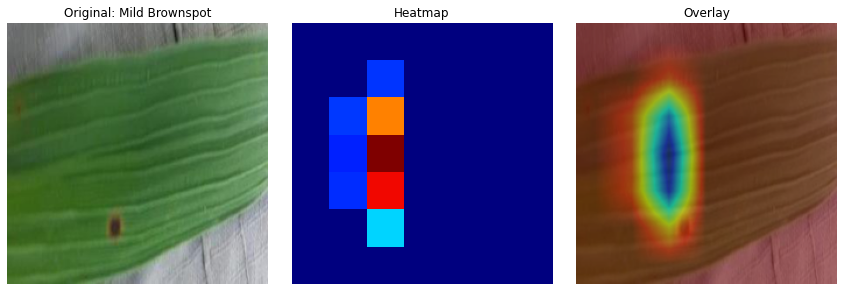

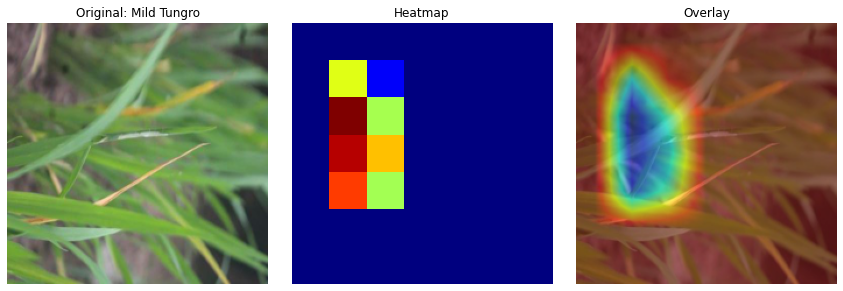

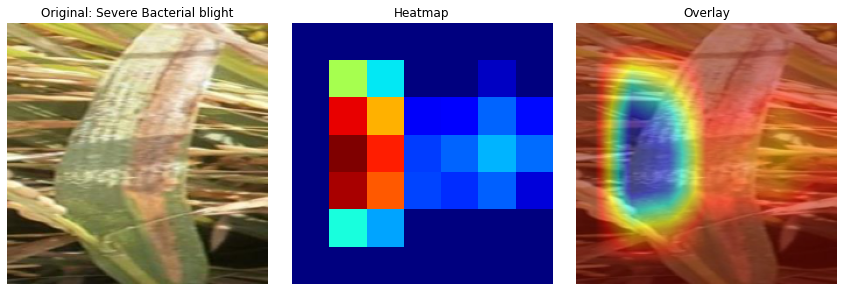

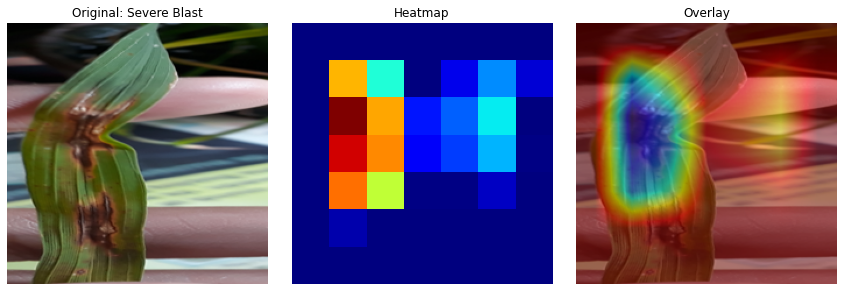

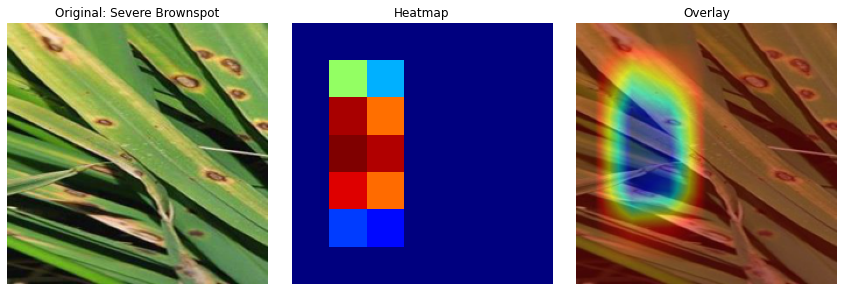

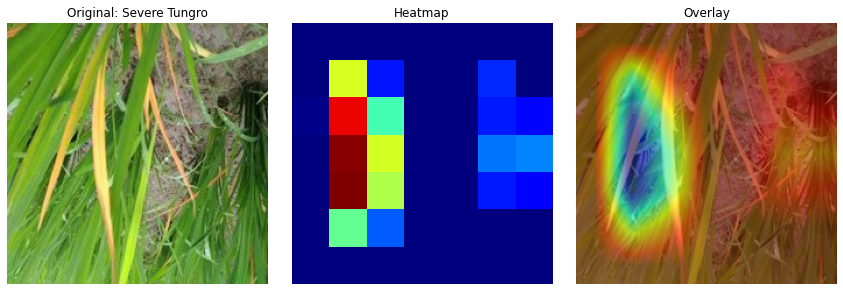

In [19]:
def find_last_conv_layer(model):
    """Returns the name of the last Conv2D layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
        elif hasattr(layer, 'layers'):
            for sublayer in reversed(layer.layers):
                if isinstance(sublayer, Conv2D):
                    return sublayer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Simplified Grad-CAM implementation"""
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        
        if len(predictions.shape) == 2:
            class_channel = predictions[:, pred_index]
        else:
            class_channel = predictions
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    
    if max_val == 0:
        h, w = heatmap.shape
        heatmap = np.ones((h, w)) * 0.1
    else:
        heatmap = heatmap / max_val
    
    return np.array(heatmap)

def display_gradcam(img, heatmap, alpha=0.5):
    """Simple overlay function"""
    # Resize heatmap to match image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert to uint8 and apply colormap
    heatmap_uint8 = np.uint8(255 * heatmap)
    colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Convert image to RGB if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Ensure both are same dtype
    img_uint8 = img.astype(np.uint8)
    
    # Blend with original image
    overlay = cv2.addWeighted(img_uint8, 1 - alpha, colored_heatmap, alpha, 0)
    
    return overlay

# Main execution
last_conv_name = find_last_conv_layer(best_model)
print(f"Using layer: {last_conv_name}")

best_indices = {}

for class_idx, class_name in enumerate(class_names):
    class_samples = np.where(y_test == class_idx)[0]

    correct_mask = class_samples[y_pred[class_samples] == class_idx]

    if len(correct_mask) > 0:
        class_probs = y_pred_probs[correct_mask, class_idx]
        best_idx = correct_mask[np.argmax(class_probs)]
    else:
        class_probs = y_pred_probs[class_samples, class_idx]
        best_idx = class_samples[np.argmax(class_probs)]

    best_indices[class_idx] = best_idx


for class_idx, class_name in enumerate(class_names):
    if class_idx in best_indices:
        best_idx = best_indices[class_idx]
        
        # Prepare image
        img_array = (x_test[best_idx] * 255.0).astype(np.uint8)
        input_array = np.expand_dims(x_test[best_idx], axis=0)
        
        # Generate heatmap
        heatmap = make_gradcam_heatmap(input_array, best_model, last_conv_name, pred_index=class_idx)
        overlay = display_gradcam(img_array, heatmap)
        
        # Simple plot with only 3 images
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        
        # Original
        ax[0].imshow(img_array.astype("uint8"))
        ax[0].set_title(f"Original: {class_name}")
        ax[0].axis("off")
        
        # Heatmap
        ax[1].imshow(heatmap, cmap="jet")
        ax[1].set_title("Heatmap")
        ax[1].axis("off")
        
        # Overlay
        ax[2].imshow(overlay)
        ax[2].set_title("Overlay")
        ax[2].axis("off")
        
        plt.tight_layout()
        plt.show()

Finding best Grad-CAM result across all classes...
Testing class: Healthy
Testing class: Mild Bacterial blight
Testing class: Mild Blast
Testing class: Mild Brownspot
Testing class: Mild Tungro
Testing class: Severe Bacterial blight
Testing class: Severe Blast
Testing class: Severe Brownspot
Testing class: Severe Tungro

*** BEST OVERALL GRAD-CAM RESULT ***
Class: Severe Bacterial blight
Sample Index: 22
Quality Score: 0.4495


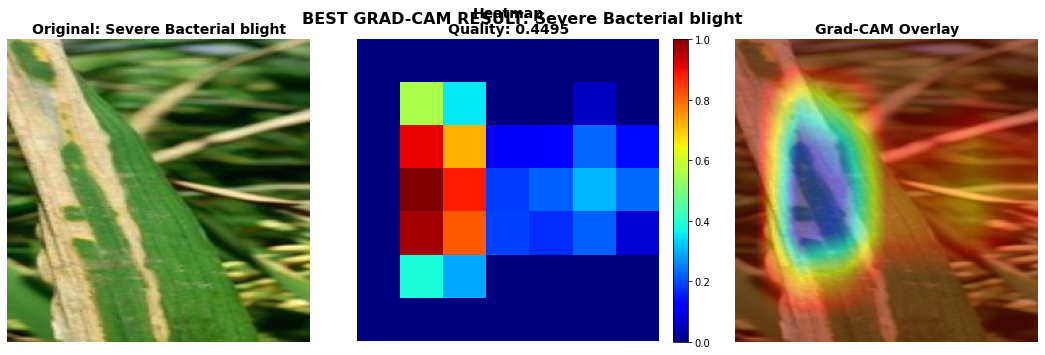

In [20]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D

def find_last_conv_layer(model):
    """Returns the name of the last Conv2D layer in the model."""
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
        elif hasattr(layer, 'layers'):
            for sublayer in reversed(layer.layers):
                if isinstance(sublayer, Conv2D):
                    return sublayer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM implementation with quality scoring"""
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    
    if max_val == 0:
        heatmap = tf.ones_like(heatmap) * 0.1
    else:
        heatmap = heatmap / max_val
    
    return heatmap.numpy()

def calculate_heatmap_quality(heatmap):
    """Calculate heatmap quality score (higher is better)"""
    heatmap_clean = heatmap[heatmap > 0.1]
    
    if len(heatmap_clean) == 0:
        return 0
    
    mean_intensity = np.mean(heatmap_clean)
    std_intensity = np.std(heatmap_clean)
    coverage = len(heatmap_clean) / heatmap.size
    contrast = std_intensity / (mean_intensity + 1e-8)
    
    quality_score = (mean_intensity * 0.3 + 
                    std_intensity * 0.3 + 
                    coverage * 0.2 + 
                    contrast * 0.2)
    
    return quality_score

def display_gradcam(img, heatmap, alpha=0.5):
    """Simple overlay function"""
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap)
    colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    img_uint8 = img.astype(np.uint8)
    overlay = cv2.addWeighted(img_uint8, 1 - alpha, colored_heatmap, alpha, 0)
    
    return overlay

# Find the best Grad-CAM result across all classes
print("Finding best Grad-CAM result across all classes...")
last_conv_name = find_last_conv_layer(best_model)

best_overall_result = None
best_quality_score = -1

for class_idx, class_name in enumerate(class_names):
    print(f"Testing class: {class_name}")
    
    class_samples = np.where(y_test == class_idx)[0]
    
    for i, sample_idx in enumerate(class_samples[:5]):
        img_array = (x_test[sample_idx] * 255.0).astype(np.uint8)
        input_array = np.expand_dims(x_test[sample_idx], axis=0)
        
        heatmap = make_gradcam_heatmap(input_array, best_model, last_conv_name, pred_index=class_idx)
        quality_score = calculate_heatmap_quality(heatmap)
        
        if quality_score > best_quality_score:
            best_quality_score = quality_score
            best_overall_result = {
                'class_idx': class_idx,
                'class_name': class_name,
                'sample_idx': sample_idx,
                'img_array': img_array,
                'heatmap': heatmap,
                'quality_score': quality_score
            }

# Display the BEST overall result
if best_overall_result:
    print(f"\n*** BEST OVERALL GRAD-CAM RESULT ***")
    print(f"Class: {best_overall_result['class_name']}")
    print(f"Sample Index: {best_overall_result['sample_idx']}")
    print(f"Quality Score: {best_overall_result['quality_score']:.4f}")
    
    overlay = display_gradcam(best_overall_result['img_array'], best_overall_result['heatmap'])
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original
    ax[0].imshow(best_overall_result['img_array'].astype("uint8"))
    ax[0].set_title(f"Original: {best_overall_result['class_name']}", fontsize=14, fontweight='bold')
    ax[0].axis("off")
    
    # Heatmap
    im = ax[1].imshow(best_overall_result['heatmap'], cmap="jet")
    ax[1].set_title(f"Heatmap\nQuality: {best_overall_result['quality_score']:.4f}", fontsize=14, fontweight='bold')
    ax[1].axis("off")
    plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    
    # Overlay
    ax[2].imshow(overlay)
    ax[2].set_title("Grad-CAM Overlay", fontsize=14, fontweight='bold')
    ax[2].axis("off")
    
    plt.suptitle(f"BEST GRAD-CAM RESULT: {best_overall_result['class_name']}", fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
    
else:
    print("No valid Grad-CAM results found!")

# References

* https://arxiv.org/abs/2201.03545

* https://github.com/facebookresearch/ConvNeXt

* https://arxiv.org/abs/1512.03385

* https://arxiv.org/abs/2103.14030

* https://arxiv.org/abs/1607.06450

* https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec

* https://paperswithcode.com/method/inverted-residual-block

* https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

* https://paperswithcode.com/method/gelu


# Citation
```bibtex
@Article{liu2022convnet,
  author  = {Zhuang Liu and Hanzi Mao and Chao-Yuan Wu and Christoph Feichtenhofer and Trevor Darrell and Saining Xie},
  title   = {A ConvNet for the 2020s},
  journal = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  year    = {2022},
}
```